In [1]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import (
    EulerSolver,
    OutputLoader,
    plot_1d_slice,
    plot_timeseries,
    plot_spacetime,
)
from superfv.initial_conditions import interacting_blast_wave_1d

In [2]:
N = 480
T = [0.006, 0.038]

ref_path = "../out/interacting_blast_wave/ref"

shared_config = dict(riemann_solver="hllc", flux_recipe=2)
vis_config = dict(vis_atol=1e-3)

MUSCL_config = dict(p=1, MUSCL=True, MUSCL_limiter="moncen", **shared_config)
ZS_config = dict(
    lazy_primitives="adaptive",
    eta_max=0.01,
    ZS=True,
    PAD={"rho": (0, None), "P": (0, None)},
    SED=True,
    **shared_config,
    **vis_config,
)
MOOD_config = dict(
    lazy_primitives="full",
    MOOD=True,
    cascade="muscl",
    MUSCL_limiter="moncen",
    max_MOOD_iters=1,
    NAD=True,
    NAD_rtol=1e-1,
    NAD_atol=1e-8,
    PAD={"rho": (0, None), "P": (0, None)},
    SED=True,
    **shared_config,
    **vis_config,
)

configs = {
    "ref": MUSCL_config,
    "MUSCL-Hancock": MUSCL_config,
    "ZS3": dict(p=3, **ZS_config),
    "MM3": dict(p=3, **MOOD_config),
    "ZS7": dict(p=7, **ZS_config),
    "MM7": dict(p=7, **MOOD_config),
}

sims = {}
for name, config in configs.items():
    if name == "ref":
        try:
            sim = OutputLoader(ref_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=interacting_blast_wave_1d,
        bcx="reflective",
        nx=10000 if name == "ref" else N,
        **config,
    )

    try:
        path = ref_path if name == "ref" else None
        snapshot_mode = "target" if name == "ref" else "every"
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=path,
            allow_overshoot=True,
            snapshot_mode=snapshot_mode,
        )
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Successfully read simulation output from "../out/interacting_blast_wave/ref"
Running MUSCL-Hancock...
Step #952 @ t=3.80e-02 | dt=4.80e-05 | min(rho)=1.48e-01, min(P)=1.90e+01 | E_cons=5.82e-11 | (ran in 1.04s)
Running ZS3...
Step #955 @ t=3.80e-02 | dt=4.79e-05 | min(rho)=1.46e-01, min(P)=1.91e+01 | E_cons=5.82e-11 | (ran in 7.29s)
Running MM3...
Step #952 @ t=3.80e-02 | dt=4.81e-05 | min(rho)=1.47e-01, min(P)=1.90e+01 | E_cons=5.82e-11 | (ran in 5.69s)
Running ZS7...
Step #951 @ t=3.80e-02 | dt=4.81e-05 | min(rho)=1.46e-01, min(P)=1.91e+01 | E_cons=8.73e-11 | (ran in 6.30s)
Running MM7...
Step #949 @ t=3.80e-02 | dt=4.83e-05 | min(rho)=1.47e-01, min(P)=1.93e+01 | E_cons=2.91e-11 | (ran in 5.87s)


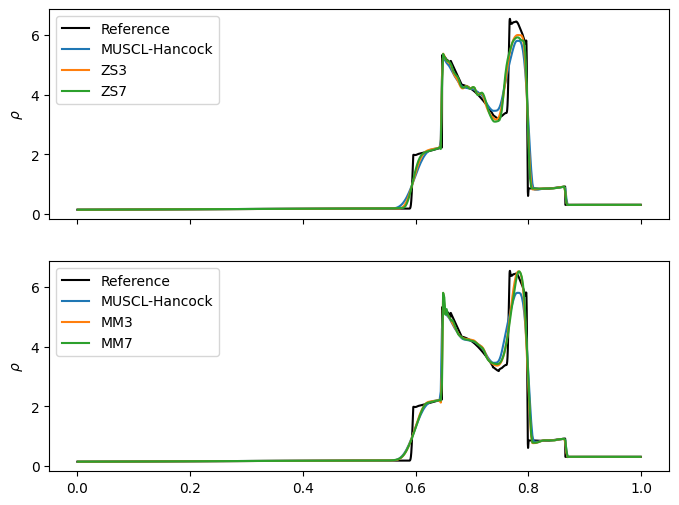

In [3]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")


ref = sims["ref"]
sim0 = sims["MUSCL-Hancock"]
sim1 = sims["ZS3"]
sim2 = sims["ZS7"]
sim3 = sims["MM3"]
sim4 = sims["MM7"]

style = dict()

# reference
plot_1d_slice(ref, axs[0], "rho", label="Reference", color="k", **style)
plot_1d_slice(ref, axs[1], "rho", label="Reference", color="k", **style)

# MUSCL-Hancock
plot_1d_slice(sim0, axs[0], "rho", label="MUSCL-Hancock", **style)
plot_1d_slice(sim0, axs[1], "rho", label="MUSCL-Hancock", **style)

# ZS3 and ZS7
plot_1d_slice(sim1, axs[0], "rho", label="ZS3", **style)
plot_1d_slice(sim2, axs[0], "rho", label="ZS7", **style)

# MM3 and MM7
plot_1d_slice(sim3, axs[1], "rho", label="MM3", **style)
plot_1d_slice(sim4, axs[1], "rho", label="MM7", **style)

axs[0].legend()
axs[1].legend()
# axs[1].set_xlim(0.5, 0.9)

(0.0, 1.0)

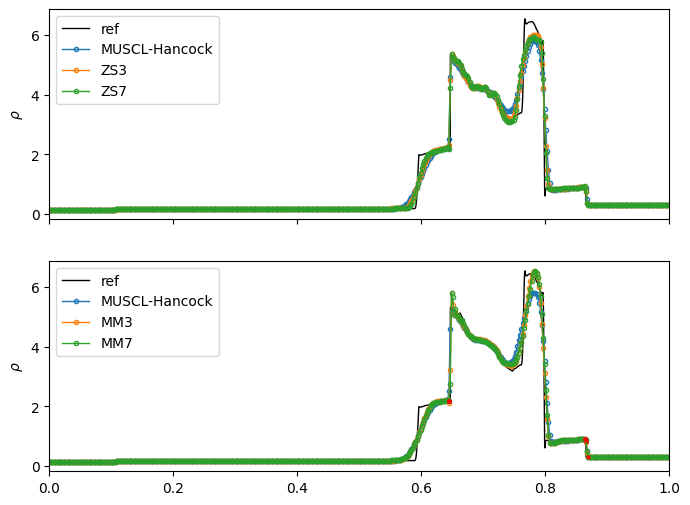

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

plot_1d_slice(sims["ref"], axs[0], "rho", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[1], "rho", label="ref", color="k", **style)

for name, sim in sims.items():
    if name == "ref":
        continue
    jlist = [0, 1] if name == "MUSCL-Hancock" else [1] if "MM" in name else [0]
    for j in jlist:
        plot_1d_slice(
            sim,
            axs[j],
            "rho",
            trouble_marker="o" if "MM" in name else None,
            label=name,
            marker="o",
            mfc="none",
            **style,
        )

axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0, 1)

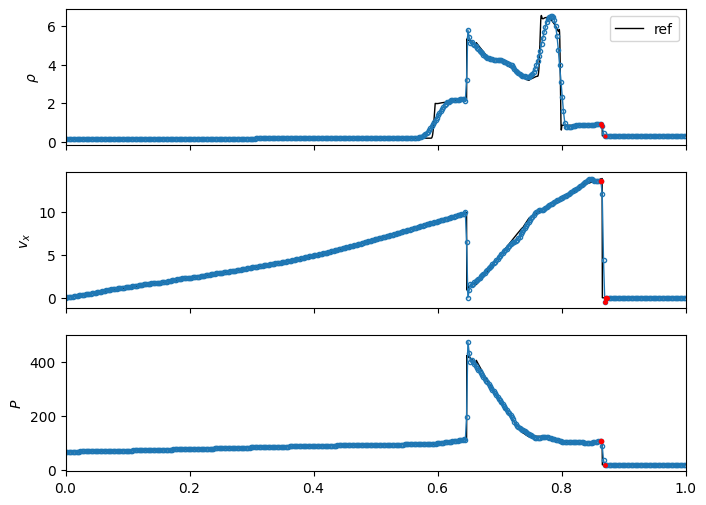

In [5]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

plot_1d_slice(sims["ref"], axs[0], "rho", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[1], "vx", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[2], "P", label="ref", color="k", **style)

sim = sims["MM3"]

plot_1d_slice(sim, axs[0], "rho", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[1], "vx", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[2], "P", marker="o", mfc="none", trouble_marker="o", **style)


axs[0].legend()

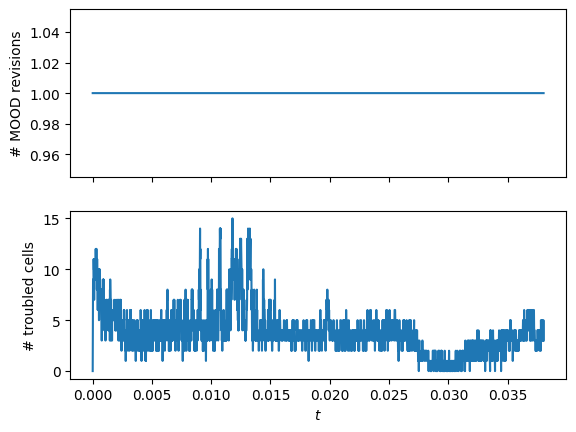

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].set_ylabel("# MOOD revisions")
axs[1].set_ylabel("# troubled cells")
axs[1].set_xlabel(r"$t$")

sim = sims["MM3"]

plot_timeseries(sim, axs[0], "nfine_MOOD_iters")
plot_timeseries(sim, axs[1], "nfine_troubles_vis_max")

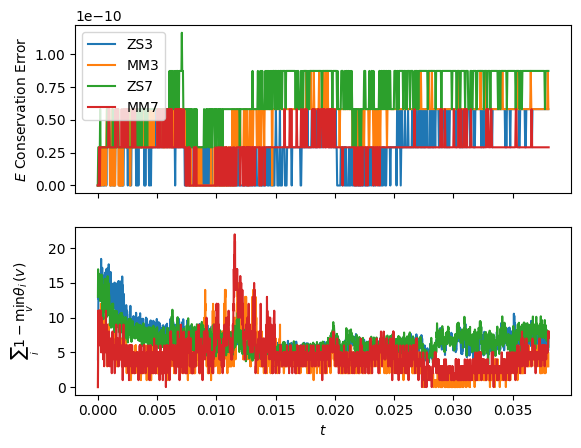

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_ylabel(r"$E$ Conservation Error")
axs[1].set_ylabel(r"$\sum_i 1 - \min_v{\theta_i(v)}$")
axs[1].set_xlabel(r"$t$")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]
sim3 = sims["ZS7"]
sim4 = sims["MM7"]

plot_timeseries(sim1, axs[0], "E_cons", label="ZS3")
plot_timeseries(sim2, axs[0], "E_cons", label="MM3")
plot_timeseries(sim3, axs[0], "E_cons", label="ZS7")
plot_timeseries(sim4, axs[0], "E_cons", label="MM7")

plot_timeseries(sim1, axs[1], "nfine_1-theta_vis_max", label="ZS3")
plot_timeseries(sim2, axs[1], "nfine_troubles_vis_max", label="MM3")
plot_timeseries(sim3, axs[1], "nfine_1-theta_vis_max", label="ZS7")
plot_timeseries(sim4, axs[1], "nfine_troubles_vis_max", label="MM7")

axs[0].legend()

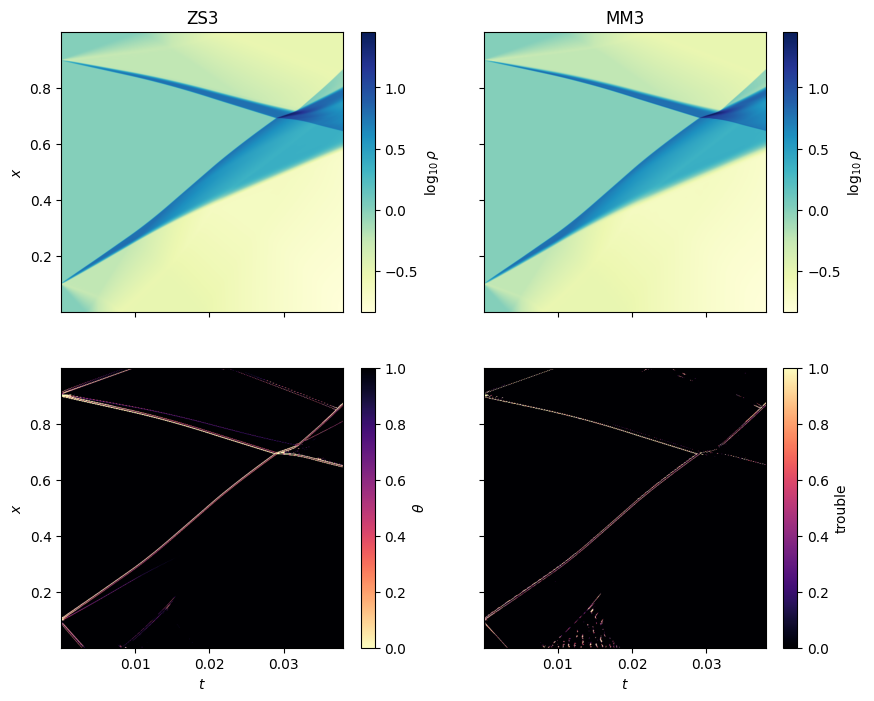

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title("ZS3")
axs[0, 1].set_title("MM3")
axs[0, 0].set_ylabel(r"$x$")
axs[1, 0].set_ylabel(r"$x$")
axs[1, 0].set_xlabel(r"$t$")
axs[1, 1].set_xlabel(r"$t$")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

rho_min = min(
    np.log10(np.min(sim1.minisnapshots["min_rho"])),
    np.log10(np.min(sim2.minisnapshots["min_rho"])),
)
rho_max = max(
    np.log10(np.max(sim1.minisnapshots["max_rho"])),
    np.log10(np.max(sim2.minisnapshots["max_rho"])),
)

rho_style = dict(
    cell_averaged=True,
    colorbar=True,
    cmap="YlGnBu",
    func=lambda x: np.log10(x),
    vmin=rho_min,
    vmax=rho_max,
)
_, cbar0 = plot_spacetime(sim1, axs[0, 0], "rho", **rho_style)
_, cbar1 = plot_spacetime(sim2, axs[0, 1], "rho", **rho_style)
cbar0.set_label(r"$\log_{10}\rho$")
cbar1.set_label(r"$\log_{10}\rho$")

trouble_style = dict(colorbar=True, vmin=0, vmax=1)
_, cbar2 = plot_spacetime(
    sim1, axs[1, 0], "min", theta=True, cmap="magma_r", **trouble_style
)
_, cbar3 = plot_spacetime(
    sim2, axs[1, 1], "max", troubles=True, cmap="magma", **trouble_style
)
cbar2.set_label(r"$\theta$")
cbar3.set_label("trouble")

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.006 not exactly matched in mesh; using nearest: 0.00599687
  warnings.warn(


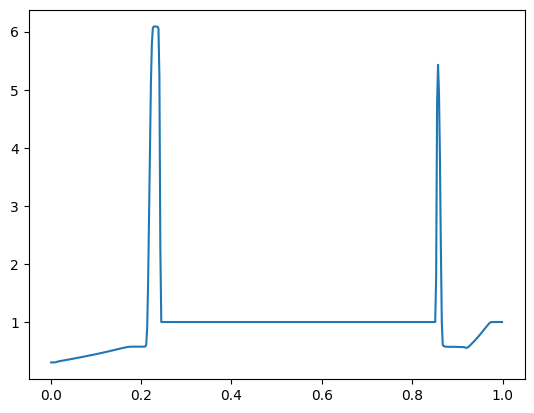

In [ ]:
fig, ax = plt.subplots()

sim = sims["ZS3"]

plot_1d_slice(sim, ax, "rho", t=0.006, cell_averaged=True, label="ZS3")

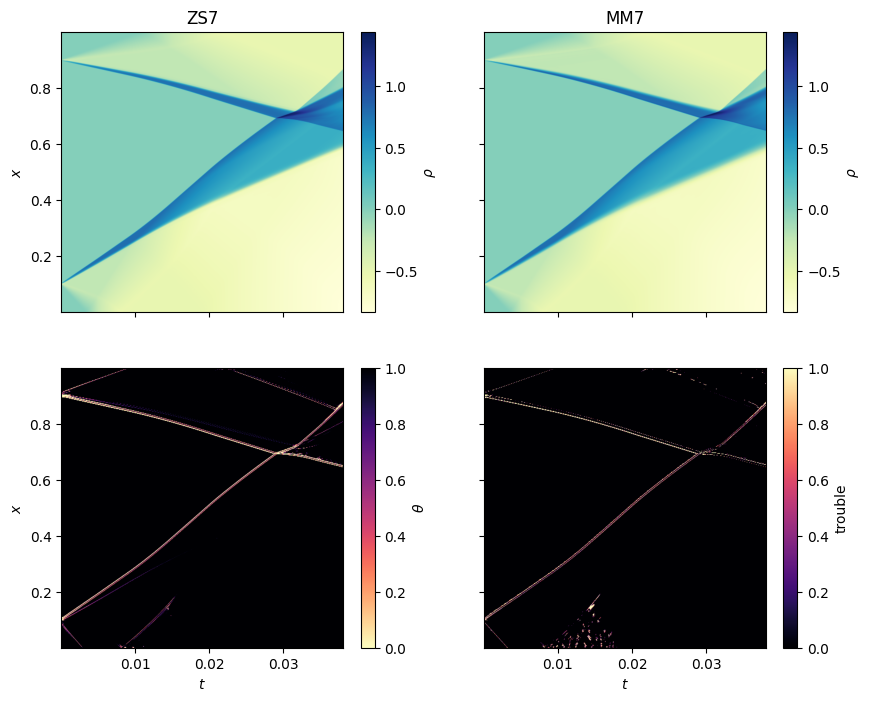

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title("ZS7")
axs[0, 1].set_title("MM7")
axs[0, 0].set_ylabel(r"$x$")
axs[1, 0].set_ylabel(r"$x$")
axs[1, 0].set_xlabel(r"$t$")
axs[1, 1].set_xlabel(r"$t$")

sim1 = sims["ZS7"]
sim2 = sims["MM7"]

rho_min = min(
    np.log10(np.min(sim1.minisnapshots["min_rho"])),
    np.log10(np.min(sim2.minisnapshots["min_rho"])),
)
rho_max = max(
    np.log10(np.max(sim1.minisnapshots["max_rho"])),
    np.log10(np.max(sim2.minisnapshots["max_rho"])),
)

rho_style = dict(
    cell_averaged=True,
    colorbar=True,
    cmap="YlGnBu",
    func=lambda x: np.log10(x),
    vmin=rho_min,
    vmax=rho_max,
)
_, cbar0 = plot_spacetime(sim1, axs[0, 0], "rho", **rho_style)
_, cbar1 = plot_spacetime(sim2, axs[0, 1], "rho", **rho_style)
cbar0.set_label(r"$\rho$")
cbar1.set_label(r"$\rho$")

trouble_style = dict(colorbar=True, vmin=0, vmax=1)
_, cbar2 = plot_spacetime(
    sim1, axs[1, 0], "min", theta=True, cmap="magma_r", **trouble_style
)
_, cbar3 = plot_spacetime(
    sim2, axs[1, 1], "max", troubles=True, cmap="magma", **trouble_style
)
cbar2.set_label(r"$\theta$")
cbar3.set_label("trouble")